In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Introduction
The purpose of this notebook is to analyze the most traded intervals of stETH/ETH pair by volume and by time. While stETH is traded on some centralized exchanges like Hotbit and has some liquidity on 1inch due to an old farming program, the vast majority of the volume and liquidity is in the Curve pool. All of the following analysis will come solely from the stETH/ETH Curve pool. To source the data, we use the web3js api, and collect all events from this pool to reconstruct the price and liquidity at every block. In addition, we also pull the wallet ids to see who is interacting with the pool. 

The [stETH/ETH pool](https://etherscan.io/address/0xdc24316b9ae028f1497c275eb9192a3ea0f67022) was created on Jan 5th, 2021 and is one of the most liquid pools on Curve with almost 1 million ETH of liquidity. Since inception, there have been two increases in the amplification factor (A parameter), which adjusts the curvature of the pool and amplifies the existing liquidity to create tighter ranges. The [first](https://etherscan.io/tx/0x3cb30e76f7e834651aa675937e01d3631dfdcf9a17c3e3e824a2a8432473c2bb) amplification change bumped the 'A' parameter from 5 to 10, while the [second](https://etherscan.io/tx/0x8e8775cb20142154dabde44935111c87e07209b3fd46a21d9aadbd13f946bed4) went from 10 to 50. A more detailed analysis of these changes will be explored in the Curve section below.

This notebook will be split into a few sections:
<ol>
  <li>Introduction on how the stETH/ETH curve pool works and pool simulations.</li>
  <li>Overview of the price action, liquidity and volume.</li>
  <li>Closer look at the decreasing volatility of the price</li>  
  <li>Closer look at volume.</li>    
  <li>Wallet tracking.</li>    
</ol>

In [2]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import lido_steth_eth
import curve_pool

cwd = os.getcwd()
data_loc = os.path.join(cwd,'data')
daily_data = pd.read_csv(os.path.join(data_loc,'daily_ETH_STETH_pool.csv'),index_col=0,parse_dates=True)
hourly_data = pd.read_csv(os.path.join(data_loc,'hourly_ETH_STETH_pool.csv'),index_col=0,parse_dates=True)
events = pd.read_csv(os.path.join(data_loc,'events_ETH_STETH_pool.csv'),index_col=0,parse_dates=True)
amp2_time_end = dt.datetime(2021,5,20)
amp2_time_start = dt.datetime(2021,5,14)
amp1_time_end = dt.datetime(2021,2,25)
amp1_time_start = dt.datetime(2021,2,19)


## 1. Curve Simulations
Curve is one of the earliest DeFi protocols and it has achieved good product market fit as an exchange for stablecoins and other assets that should be pegged close to 1:1. The [stableswap whitepaper](https://curve.fi/files/stableswap-paper.pdf) breaks down the math behind the curve pools and how it is different from a typical XY=K model like UniswapV2. Curve combines the constant product approach that UniswapV2 uses along with the constant sum formula to create a hybrid approach that mimics a really thick book in a narrow band, while still providing liquidity across the entire spectrum. 

The math behind the Curve pool is out of the scope of this article, but we can simulate the price of ETH/stETH by varying our two main parameters: the 'A' parameter and the amount of liquidity in the pool. The pool started out with around 100,000 ETH and stETH and has since grown 10x to about 1,000,000 ETH and stETH. 

Fixing the pool size at 1,000,000 ETH and stETH, we vary the A parameter from 5 (where it started out) to 10 (after middle of Feburary) to 50 (after middle of May) and look at the price slippage of trading ETH to stETH. We can see that the larger the A parameter is the less the slippage is. For reference the largest trade to date in the pool was a little under 9k and we can see the slippage for A = 50 is almost 10x lower than A = 5 at this trade size.

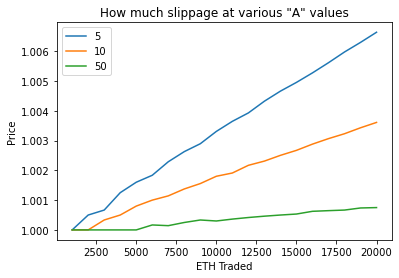

Price to trade 9000
5     1.002897
10    1.001558
50    1.000333
Name: 9000, dtype: float64


In [3]:
A_list = [5, 10, 50]
dx_list = np.arange(1000,21000,1000)
pool_size = 1000000
for i,A in enumerate(A_list): 
    pool = curve_pool.Curve(A,pool_size,2)
    traded_curve = lido_steth_eth.get_dx_dy_pool(pool,dx_list,col_names = ['ETH','stETH'])
    traded_curve.set_index('ETH',inplace=True)
    if i==0:
        full_frame = traded_curve[['price']]
        full_frame.columns = [A]
    else:
        full_frame[A] = traded_curve['price']
full_frame.plot()
plt.title('How much slippage at various "A" values')
plt.ylabel('Price')
plt.xlabel('ETH Traded')
plt.show()

amount_traded = 9000
print('Price to trade '+str(amount_traded))
print(full_frame.loc[amount_traded])

Below we can do the same test, this time fixing A at 50 and varying the pool size from 100,000 (the start) to 500,000 (around May) and finally our current pool size of 1,000,000 ETH and stETH. We see a similar trend of the 1,000,000 liquidity pool be almost 10x more efficient in terms of slippage as the 100,000 pool at the max traded 9,000 size.


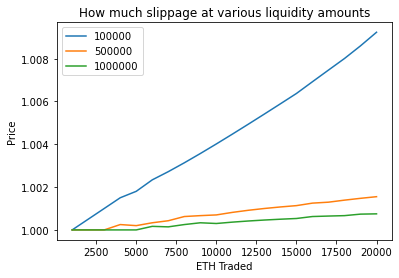

Price to trade 9000
100000     1.003568
500000     1.000667
1000000    1.000333
Name: 9000, dtype: float64


In [4]:
A = 50
pool_size_list = [100000, 500000, 1000000]
for i,pool_size in enumerate(pool_size_list): 
    pool = curve_pool.Curve(A,pool_size,2)
    traded_curve = lido_steth_eth.get_dx_dy_pool(pool,dx_list,col_names = ['ETH','stETH'])
    traded_curve.set_index('ETH',inplace=True)
    if i==0:
        full_frame = traded_curve[['price']]
        full_frame.columns = [pool_size]
    else:
        full_frame[pool_size] = traded_curve['price']

full_frame.plot()
plt.title('How much slippage at various liquidity amounts')
plt.ylabel('Price')
plt.xlabel('ETH Traded')
plt.show()

amount_traded = 9000
print('Price to trade '+str(amount_traded))
print(full_frame.loc[amount_traded])

## 2. Overview of Pool
Below we have three timeseries plots, one of the ETH/stETH price, one of the total liquidity in the pool, and one of the volume. In addition, there are red lines from when the amplification parameter was changed. We can see that early on, there was a decent amount of volatility even as the ETH in the pool was climbing due to liquidity mining. Even after the first A parameter change, there was still a decent amount of volatility as people withdrew from the pool and liquidity fell around February and March.

During this drop, there was the low point of the ETH/stETH trade where we saw values of .96 and .97 for an entire month, but those dips where rapidly bought and liquidity started increasing around April and has continued to this day. In tandem with the liquidity increase, the 'A' parameter change in late May seems to have really tapered the volatility of this pair as the prices have not been off by 1% since. Please note that the price of .99 means it takes .99 ETH to buy 1 stETH.

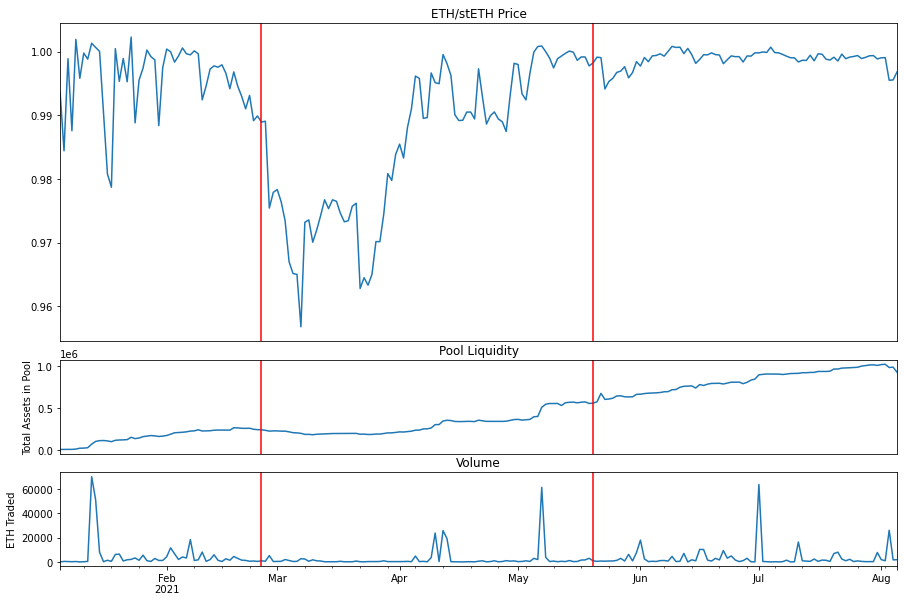

In [5]:
top = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
daily_data['price'].plot()
top.axes.get_xaxis().set_visible(False)
plt.axvline(x=amp1_time_end,color='r')
plt.axvline(x=amp2_time_end,color='r')
plt.title('ETH/stETH Price')

bottom2 = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
(daily_data['ETH_Pool']+daily_data['STETH_Pool']).plot()
bottom2.axes.get_xaxis().set_visible(False)
plt.axvline(x=amp1_time_end,color='r')
plt.axvline(x=amp2_time_end,color='r')
plt.ylabel('Total Assets in Pool')
plt.title('Pool Liquidity')

bottom = plt.subplot2grid((5,4), (4,0), rowspan=1, colspan=4)
daily_data['Volume'].plot()
plt.title('Volume')
plt.ylabel('ETH Traded')
plt.axvline(x=amp1_time_end,color='r')
plt.axvline(x=amp2_time_end,color='r')
plt.gcf().set_size_inches(15,10)

## 3. Decreasing Volatility
### Specific Traded Intervals
Going into more detail, we can the exact price points the ETH/stETH pair traded. Over the entire lifespan of the pool, most of the trades are in the 1% delta range of "fair" value, but there were over 8,000 ETH traded below .97 and another 20,000 between .97-.98 and .98-.99.

Since the second 'A' parameter change we have been in a very narrow band, from .994 to 1.002 with most of the volume concentrated between .998 and 1.001.

In [6]:
events_vol_group = events.groupby(pd.cut(events["price"], [0,.97,.98,.99,1,1.01,1.02]))['Volume'].sum()
plot_bar_with_annotation(events_vol_group,title='Volume at Each Price (Lifespan)', ylabel='Volume (ETH)',xlabel='Price Range', figsize=(8, 6))


NameError: name 'plot_bar_with_annotation' is not defined

In [ ]:
amp_events = events[events.index>amp2_time_end]
events_vol_group_amp = amp_events.groupby(pd.cut(amp_events["price"], np.arange(0.994, 1.0031, 0.001)))['Volume'].sum()
plot_bar_with_annotation(events_vol_group_amp,title="Volume at Price after 'A' Param Change", ylabel='Volume (ETH)',xlabel='Price Range', figsize=(8, 6))


### Rolling Range
Another way to observe the dampened volatility is to look at the rolling price range. Using a rolling 2 week price range, we take the highest and lowest price in that period and diff them to come up with an absolute range. To put this into perspective, before May the pool had 1 to 3.5% bi-weekly moves, but it now has less than .05% bi-weekly moves.

In [ ]:
rolling_days = 14
daily_data['price'].rolling(rolling_days).apply(lambda x: x.max()-x.min()).plot()
plt.axvline(x=amp2_time_end,color='r')
plt.title('Rolling ' +str(rolling_days)+ ' day price range')
plt.ylabel('Price Range')
plt.show()

## 4. Volumes
Compared to the liquidity, there is not that much volume being traded, hinting that most people are long term holders. There are occasional large transactions but generally only around 500 ETH is traded each day. 

Diving a little deeper at the median daily volumes, we can see that Friday and Saturday have the lowest median volumes which is in line with most of crypto. Going into the weekend there is typically less activity than a weekday.

In [ ]:
day_of_week_volume = daily_data.groupby(daily_data.index.dayofweek)['Volume'].describe()
day_of_week_volume.index = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
day_of_week_volume['50%'].plot(kind='bar')
plt.title('Median Volumes')
plt.ylabel('ETH Traded')
plt.show()

We can also break down the hourly volumes into various timezone sessions. There are 3 main trading sessions in traditional finance and we group our hourly data into the following buckets (Bitmex actually follows these exact hours for their popular perputual future)
<ol>
  <li>US: 12 UTC to 20 UTC</li>
  <li>Asia: 20 UTC to 4 UTC</li>
  <li>Europe 4 UTC to 12 UTC</li>  
</ol>

From this we see that the hourly volumes are extremely right tailed, as the mean is closer to the 90th percentile than the 50th percentile of volumes. This means that most of the time theres not that much volume but some hours substantially more than others. Given that the median is under 5 ETH traded per hour and the 90th percentile and mean are around 100 ETH, we can see that the trades are not evenly distributed at all and some sessions trade 20x the volume of others. 

Another interesting observation is that the mean of each hourly volume during the US session is so much higher than the mean of the Asian and European sessions, but the 50th percentile and 90th percentile have similar numbers. This hints that the largest trades occur in the US session from 12 UTC to 20 UTC. Looking closer at the data, the top 6 hourly volumes all occur in the US session.

In [ ]:
hourly_data['hours'] = hourly_data.index.hour
hourly_data['sessions'] = hourly_data['hours'].apply(lambda x :sort_utc_session(x))
session_data = hourly_data.groupby(hourly_data['sessions'])['Volume'].describe()[['50%']]
session_data['90%'] = hourly_data.groupby(hourly_data['sessions'])['Volume'].quantile(.9)
session_data['Mean'] = hourly_data.groupby(hourly_data['sessions'])['Volume'].mean()
session_data.plot(kind='bar')
plt.title('Average Hourly Volume in Each Session')
plt.ylabel('ETH Traded')
plt.show()
print(hourly_data.sort_values('Volume',ascending=False)[['Volume','sessions']].head(6).round(2))

## 5. Wallet Tracking
Aggregating the wallet ids of those who interacted with the pool we can see the amount of users trading, providing liquidity, and the breakdown of how much volume/liquidity are whales. 

In [ ]:
events['total_amount'] = abs(events['eth_amount']) + abs(events['steth_amount'])
liq_events = events[events['event'].isin(['AddLiquidity', 'RemoveLiquidity', 'RemoveLiquidityImbalance','RemoveLiquidityOne'])]
unique_liquidity_wallets = np.unique(liq_events['walletid'])
unique_exchange_wallets = np.unique(events[events['event']=='TokenExchange']['walletid'])
only_liquidity_wallets = np.setdiff1d(unique_liquidity_wallets,unique_exchange_wallets)
only_exchange_wallets = np.setdiff1d(unique_exchange_wallets,unique_liquidity_wallets)
both_liquidity_and_exchange_wallets = set(unique_liquidity_wallets) & set(unique_exchange_wallets)

print('There are ' + str(len(np.unique(events['walletid']))) + str(' unique wallets interacting with the pool since launch.'))
print(str(len(only_liquidity_wallets))+ ' wallets have only provided liquidity.')
print(str(len(only_exchange_wallets))+ ' wallets have only traded.')
print(str(len(both_liquidity_and_exchange_wallets))+ ' wallets have both provided liquidity and traded.')

In [ ]:
wallet_volume_percentage = events.groupby('walletid')['Volume'].sum().sort_values()/events['Volume'].sum()
wallet_liq_precentage = liq_events.groupby('walletid')['total_amount'].sum().sort_values()/events['total_amount'].sum()

print('There are ' + str(len(wallet_volume_percentage[wallet_volume_percentage>.01])) + ' wallets which have each traded over 1% each of the total traded pool volume.')
print('These wallets trade: ' + str((100*wallet_volume_percentage[wallet_volume_percentage>.01].sum()).round(2)) + '% of the pool volume.')
print('There are ' + str(len(wallet_liq_precentage[wallet_liq_precentage>.01])) + ' wallets which have each provided over 1% of the total liquidity')
print('These wallets provided: ' + str((100*wallet_liq_precentage[wallet_liq_precentage>.01].sum()).round(2)) + '% of the pool liquidity.')




## 6. Conclusion
At the current states, the pools are exceedingly thick. Given a balanced amount of both assets, it will take over 200k ETH to move the price over 1%, over 20x the largest trade in the book. As long as the pool keeps being subsidized, I see no reason for liquidity to disappear, in fact looking at trends, there should be more liquidity as we get closer to the merge and the additional liquidity will drop volatility even further.
